In [61]:
# ========================= Base CNN model Full Pipeline =========================
import os
import numpy as np
import cv2
import nibabel as nib
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Input, GlobalAveragePooling2D, BatchNormalization, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# --- Label Map (5-class setup) ---
label_map = {'NOR': 0, 'MINF': 1, 'DCM': 2, 'HCM': 3, 'ARV': 4}

# --- Parse Info.cfg to extract ED/ES frame and diagnosis group ---
def parse_info_cfg(info_path):
    ed_frame = es_frame = group = None
    with open(info_path, 'r') as f:
        for line in f:
            if line.startswith("ED:"):
                ed_frame = int(line.split(":")[1].strip())
            elif line.startswith("ES:"):
                es_frame = int(line.split(":")[1].strip())
            elif line.startswith("Group:"):
                group = line.split(":")[1].strip()
                if group == "RV":  # Standardize ARV naming
                    group = "ARV"
    return ed_frame, es_frame, group

# --- Load middle slice from NIfTI image and resize ---
def load_mid_slice(filepath):
    img = nib.load(filepath).get_fdata()
    mid = img.shape[2] // 2
    return cv2.resize(img[:, :, mid], (128, 128))

# --- Stack ED and ES slices into 2-channel input ---
def load_patient_tensor(patient_path, patient_id, ed, es):
    ed_img = load_mid_slice(f"{patient_path}/{patient_id}_frame{ed:02d}.nii")
    es_img = load_mid_slice(f"{patient_path}/{patient_id}_frame{es:02d}.nii")
    stacked = np.stack([ed_img, es_img], axis=-1)
    return stacked / np.max(stacked)

# --- Load all patient data from folder ---
def load_dataset(base_dir):
    X, y = [], []
    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"): continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            label = label_map[group]
            tensor = load_patient_tensor(path, patient, ed, es)
            X.append(tensor)
            y.append(label)
        except Exception as e:
            print(f"⚠️ Skipping {patient}: {e}")
    return np.array(X), to_categorical(y, num_classes=5)

# --- Base CNN model (used for early trials) ---
def build_cnn_model(input_shape=(128, 128, 2), num_classes=5, learning_rate=0.0005):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# ========== ⬇️ Initial 5-Class Classification Setup (Raw CNN) ==========

print("📥 Loading training data...")
X_train, y_train = load_dataset("./database/training")

print("\n📥 Loading testing data...")
X_test, y_test = load_dataset("./database/testing")

# Sanity check
print("🔍 Train label distribution:", np.sum(y_train, axis=0))
print("🔍 Test label distribution:", np.sum(y_test, axis=0))

# Train base CNN model
print("\n🧠 Training basic CNN model...")
model = build_cnn_model(input_shape=(128, 128, 2), learning_rate=0.0005) 
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

# Evaluate
print("\n🧪 Evaluating on test set...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("🔍 Predicted label distribution:", np.bincount(y_pred))
print(f"🎯 Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys()), zero_division=0))

📥 Loading training data...


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s]



📥 Loading testing data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.47it/s]


🔍 Train label distribution: [20. 20. 20. 20. 20.]
🔍 Test label distribution: [10. 10. 10. 10. 10.]

🧠 Training basic CNN model...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.0819 - loss: 1.6141
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2373 - loss: 1.6028
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.1807 - loss: 1.6061
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2333 - loss: 1.6001
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2493 - loss: 1.5980
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2293 - loss: 1.6042
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.2473 - loss: 1.6055
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.2790 - loss: 1.6051
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2640 - loss: 1.6012
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2444 - loss: 1.5933
Epoch 11/30
7/7 ━━━━━━━━━━━━

In [7]:
# ========== ⬇️ EDA: Simplifying to Binary Classification ==========

# Update label map for binary classification
binary_label_map = {'NOR': 0, 'MINF': 1, 'DCM': 1, 'HCM': 1}  # Removed ARV

def load_binary_dataset(base_dir):
    X, y = [], []
    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"): continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            if group == 'ARV': continue  # Exclude ARV
            label = binary_label_map[group]
            tensor = load_patient_tensor(path, patient, ed, es)
            X.append(tensor)
            y.append(label)
        except Exception as e:
            print(f"⚠️ Skipping {patient}: {e}")
    return np.array(X), to_categorical(y, num_classes=2)

# Load binary classification data
print("\n📥 Loading binary classification data...")
X_train_bin, y_train_bin = load_binary_dataset("./database/training")
X_test_bin, y_test_bin = load_binary_dataset("./database/testing")

# Train model with binary classification
print("\n🧠 Training model for binary classification...")
model_bin = build_cnn_model(input_shape=(128, 128, 2), num_classes=2, learning_rate=0.0005)
model_bin.fit(X_train_bin, y_train_bin, epochs=30, batch_size=16, verbose=1)

y_pred_bin = np.argmax(model_bin.predict(X_test_bin), axis=1)
y_true_bin = np.argmax(y_test_bin, axis=1)

print(f"\n🎯 Binary Test Accuracy: {accuracy_score(y_true_bin, y_pred_bin):.4f}")
print("\n📊 Binary Classification Report:")
print(classification_report(y_true_bin, y_pred_bin, target_names=["Normal", "Abnormal"], zero_division=0))


# ========== ⬇️ EDA: Enhanced CNN Architecture with More Hidden Layers ==========

def build_deep_cnn(input_shape=(128, 128, 2), num_classes=2, learning_rate=0.0005):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train deep CNN
print("\n🧠 Training deeper CNN model...")
model_deep = build_deep_cnn()
model_deep.fit(X_train_bin, y_train_bin, epochs=30, batch_size=16, verbose=1)

# Evaluate
y_pred_deep = np.argmax(model_deep.predict(X_test_bin), axis=1)
print(f"\n🎯 Deep CNN Accuracy: {accuracy_score(y_true_bin, y_pred_deep):.4f}")


📥 Loading binary classification data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 72.26it/s]



🧠 Training model for binary classification...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.6023 - loss: 0.6842
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.7413 - loss: 0.5968
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8021 - loss: 0.5200
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7856 - loss: 0.5400
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.7569 - loss: 0.5429
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8056 - loss: 0.5097
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7665 - loss: 0.5298
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.7752 - loss: 0.5377
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - accuracy: 0.7595 - loss: 0.5438
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.7387 - loss: 0.5786
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.7604 - loss: 0.5341
Epoch 12/30
5/5 ━━━━━━━━━━━

In [11]:
# ========================= Simple CNN Multi-Head Model Full Pipeline =========================
import os
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

# === Load & Preprocess Data ===
def parse_info_cfg(info_path):
    ed = es = group = None
    with open(info_path, 'r') as f:
        for line in f:
            if "ED:" in line:
                ed = int(line.split(":")[1].strip())
            elif "ES:" in line:
                es = int(line.split(":")[1].strip())
            elif "Group:" in line:
                group = line.split(":")[1].strip()
                if group == "RV":
                    group = "ARV"
    return ed, es, group

def load_mid_slice(path):
    img = nib.load(path).get_fdata()
    mid = img.shape[2] // 2
    return cv2.resize(img[:, :, mid], (128, 128))

def load_tensor(base_path, pid, ed, es):
    ed_img = load_mid_slice(f"{base_path}/{pid}_frame{ed:02d}_gt.nii")
    es_img = load_mid_slice(f"{base_path}/{pid}_frame{es:02d}_gt.nii")
    tensor = np.stack([ed_img, es_img], axis=-1)
    return tensor / np.max(tensor)

def load_dataset_multihead(base_dir):
    X = []
    y_all = {'NOR': [], 'MINF': [], 'DCM': [], 'HCM': [], 'ARV': []}
    classes = list(y_all.keys())

    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"):
            continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            tensor = load_tensor(path, patient, ed, es)
            X.append(tensor)

            for cls in classes:
                y_all[cls].append(1 if cls == group else 0)
        except Exception as e:
            print(f" Skipping {patient}: {e}")

    X = np.array(X)
    y_outs = [np.array(y_all[cls]) for cls in classes]
    return X, y_outs, classes

# === Build Simple CNN Multi-Head Model ===
def build_simple_multihead_model(input_shape=(128, 128, 2),
                                 class_names=['NOR', 'MINF', 'DCM', 'HCM', 'ARV'],
                                 learning_rate=0.0003):   # lower LR
    
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = []
    losses = {}
    metrics = {}

    for cls in class_names:
        head_name = f"{cls}_head"
        head_output = Dense(1, activation='sigmoid', name=head_name)(x)
        outputs.append(head_output)

        losses[head_name] = 'binary_crossentropy'
        metrics[head_name] = [
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=losses,
        metrics=metrics
    )

    return model

# === Export Predictions ===
def export_predictions(model, X_test, y_test_list, class_names, output_csv="prediction_results.csv"):
    y_pred_probs = model.predict(X_test)
    y_pred_bin = [(p > 0.5).astype(int).flatten() for p in y_pred_probs]
    y_pred_matrix = np.stack(y_pred_bin, axis=1)
    y_pred_probs_matrix = np.stack([p.flatten() for p in y_pred_probs], axis=1)

    true_class_indices = [
        next(j for j in range(len(class_names)) if y_test_list[j][i] == 1)
        for i in range(len(X_test))
    ]
    true_class_names = [class_names[i] for i in true_class_indices]

    predicted_sets = [
        [class_names[j] for j in range(len(class_names)) if y_pred_matrix[i][j] == 1]
        for i in range(len(X_test))
    ]

    containment_match = [
        true_class_names[i] in predicted_sets[i]
        for i in range(len(X_test))
    ]
    top1_indices = np.argmax(y_pred_probs_matrix, axis=1)
    top1_preds = [class_names[i] for i in top1_indices]
    correct_top1 = [
        top1_preds[i] == true_class_names[i]
        for i in range(len(X_test))
    ]

    patient_ids = sorted([pid for pid in os.listdir('./database/testing') if pid.startswith("patient")])

    df = pd.DataFrame({
        'PatientID': patient_ids,
        'True_Label': true_class_names,
        'Top1_Pred': top1_preds,
        'Predicted_Binary': predicted_sets,
        'Correctly_Contained': containment_match,
        'Correct_Top1': correct_top1
    })

    df.to_csv(output_csv, index=False)
    print(f" Saved predictions to {output_csv}")
    return df

# === Main Execution ===
if __name__ == "__main__":
    print(" Loading training and testing data...")
    X_train, y_train_list, class_names = load_dataset_multihead('./database/training')
    X_test, y_test_list, _ = load_dataset_multihead('./database/testing')

    print(" Building model...")
    model = build_simple_multihead_model(
        input_shape=(128, 128, 2),
        class_names=class_names
    )

    print(" Training model...")
    model.fit(
        X_train,
        y_train_list,
        validation_data=(X_test, y_test_list),
        epochs=200,
        batch_size=16,
        verbose=1
    )

    print(" Predicting and exporting results...")
    export_predictions(model, X_test, y_test_list, class_names)

 Loading training and testing data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.08it/s]


 Building model...
 Training model...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 850ms/step - ARV_head_accuracy: 0.7484 - ARV_head_loss: 0.6203 - ARV_head_precision: 0.0000e+00 - ARV_head_recall: 0.0000e+00 - DCM_head_accuracy: 0.7035 - DCM_head_loss: 0.6651 - DCM_head_precision: 0.2727 - DCM_head_recall: 0.3547 - HCM_head_accuracy: 0.8298 - HCM_head_loss: 0.6167 - HCM_head_precision: 0.5000 - HCM_head_recall: 0.1474 - MINF_head_accuracy: 0.7153 - MINF_head_loss: 0.6067 - MINF_head_precision: 0.0000e+00 - MINF_head_recall: 0.0000e+00 - NOR_head_accuracy: 0.6784 - NOR_head_loss: 0.6148 - NOR_head_precision: 0.2500 - NOR_head_recall: 0.3644 - loss: 3.1392 - val_ARV_head_accuracy: 0.8000 - val_ARV_head_loss: 0.4239 - val_ARV_head_precision: 0.0000e+00 - val_ARV_head_recall: 0.0000e+00 - val_DCM_head_accuracy: 0.8000 - val_DCM_head_loss: 0.6462 - val_DCM_head_precision: 0.0000e+00 - val_DCM_head_recall: 0.0000e+00 - val_HCM_head_accuracy: 0.8000 - val_HCM_head_loss: 0.4292 - val_HCM_head_pre

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === Load Saved Predictions ===
df = pd.read_csv("prediction_results.csv")

# === Define Class Names ===
class_names = ['NOR', 'MINF', 'DCM', 'HCM', 'ARV']

# === Convert Labels to Indices ===
true_labels = df['True_Label'].map({cls: i for i, cls in enumerate(class_names)})
pred_labels = df['Top1_Pred'].map({cls: i for i, cls in enumerate(class_names)})

# === Confusion Matrix ===
cm = confusion_matrix(true_labels, pred_labels)
print(" Confusion Matrix:")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

# === Classification Report ===
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Round for readability
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)
print("\n Classification Report:")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

 Confusion Matrix:
      NOR  MINF  DCM  HCM  ARV
NOR     3     2    0    3    2
MINF    3     5    1    1    0
DCM     1     2    7    0    0
HCM     3     0    0    5    2
ARV     2     1    0    1    6

 Classification Report:
              precision  recall  f1-score  support
NOR               0.250    0.30     0.273    10.00
MINF              0.500    0.50     0.500    10.00
DCM               0.875    0.70     0.778    10.00
HCM               0.500    0.50     0.500    10.00
ARV               0.600    0.60     0.600    10.00
accuracy          0.520    0.52     0.520     0.52
macro avg         0.545    0.52     0.530    50.00
weighted avg      0.545    0.52     0.530    50.00


In [15]:
# === Print Overall Accuracy ===
accuracy = report['accuracy']
print(f"\n Overall Accuracy: {accuracy:.3f}")


 Overall Accuracy: 0.520


In [17]:
# === Save Model to Disk ===
model.save("multihead_cnn_model_0.5.keras")
print(" Model saved to multihead_cnn_model0.5.keras")

 Model saved to multihead_cnn_model0.5.keras


In [89]:
# ========================= Simple Binary CNN Full Pipeline =========================
# === Imports ===
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix

# === Set Random Seeds for Reproducibility ===
def set_seeds(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === Load & Preprocess Data ===
def parse_info_cfg(info_path):
    ed = es = group = None
    with open(info_path, 'r') as f:
        for line in f:
            if "ED:" in line:
                ed = int(line.split(":")[1].strip())
            elif "ES:" in line:
                es = int(line.split(":")[1].strip())
            elif "Group:" in line:
                group = line.split(":")[1].strip()
    return ed, es, group

def load_mid_slice(path):
    img = nib.load(path).get_fdata()
    mid = img.shape[2] // 2
    return cv2.resize(img[:, :, mid], (128, 128))

def load_tensor(base_path, pid, ed, es):
    ed_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{ed:02d}_gt.nii"))
    es_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{es:02d}_gt.nii"))
    tensor = np.stack([ed_img, es_img], axis=-1)
    tensor = tensor.astype(np.float32)
    return tensor / np.max(tensor)

def load_dataset_binary(base_dir):
    X = []
    y = []

    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"):
            continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            if group == "ARV":
                continue
            tensor = load_tensor(path, patient, ed, es)
            X.append(tensor)
            label = 0 if group == "NOR" else 1
            y.append(label)
        except Exception as e:
            print(f"Skipping {patient}: {e}")

    X = np.stack(X, axis=0)
    y = np.array(y)
    return X, y

# === Build Simple Binary CNN ===
def build_binary_model(input_shape=(128, 128, 2), learning_rate=0.0003):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

# === Export Predictions ===
def export_predictions_binary(model, X_test, y_test, output_csv="prediction_results_binary.csv"):
    y_pred_probs = model.predict(X_test, batch_size=16).flatten()
    y_pred_bin = (y_pred_probs > 0.5).astype(int)

    patient_ids = sorted([pid for pid in os.listdir('./database/testing') if pid.startswith("patient")])
    if len(patient_ids) != len(y_pred_bin):
        patient_ids = patient_ids[:len(y_pred_bin)]

    df = pd.DataFrame({
        'PatientID': patient_ids,
        'True_Label': y_test,
        'Pred_Prob': y_pred_probs,
        'Pred_Label': y_pred_bin,
        'Correct': y_test == y_pred_bin
    })

    df.to_csv(output_csv, index=False)
    print(f"Saved predictions to {output_csv}")
    return df

# === Main Execution ===
if __name__ == "__main__":
    print("Setting seeds for reproducibility...")
    set_seeds(42)

    print("Loading training and testing data...")
    X_train, y_train = load_dataset_binary('./database/training')
    X_test, y_test = load_dataset_binary('./database/testing')

    print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

    print("Building simple CNN model...")
    model = build_binary_model(input_shape=(128, 128, 2))

    print("Training model...")
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=16,
        verbose=1
    )

    print("Predicting and exporting results...")
    df = export_predictions_binary(model, X_test, y_test)

    # === Evaluation ===
    cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
    print("\nConfusion Matrix (Simple CNN):")
    print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["Pred: NOR", "Pred: ABN"]))

    report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

    print("\nClassification Report (Simple CNN):")
    print(report_df[['precision', 'recall', 'f1-score', 'support']])


 Loading training and testing data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 48.07it/s]


 Building model...
 Training model...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.7095 - loss: 0.5866 - precision: 0.8140 - recall: 0.8439 - val_accuracy: 0.8000 - val_loss: 0.4791 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8177 - loss: 0.4274 - precision: 0.8177 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.4465 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.8177 - loss: 0.4081 - precision: 0.8177 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.4580 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8177 - loss: 0.3930 - precision: 0.8177 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.4446 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8177 - loss: 0.3774 - precision: 0.8177 - recall: 1.0000 - va

In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === Load Predictions ===
df = pd.read_csv("prediction_results_binary.csv")

# === Confusion Matrix ===
cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["NOR", "ABN"]))

# === Classification Report ===
report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

print("\nClassification Report:")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

Confusion Matrix:
     NOR  ABN
NOR    3    7
ABN    6   34

Classification Report:
              precision  recall  f1-score  support
NOR               0.333   0.300     0.316    10.00
ABN               0.829   0.850     0.840    40.00
accuracy          0.740   0.740     0.740     0.74
macro avg         0.581   0.575     0.578    50.00
weighted avg      0.730   0.740     0.735    50.00


In [99]:
# === Print Overall Accuracy ===
accuracy = report['accuracy']
print(f"\n Overall Accuracy: {accuracy:.3f}")


 Overall Accuracy: 0.740


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
 Saved predictions to prediction_results_binary.csv

Evaluation Metrics:
  ROC AUC: 0.721
  PR AUC:  0.910


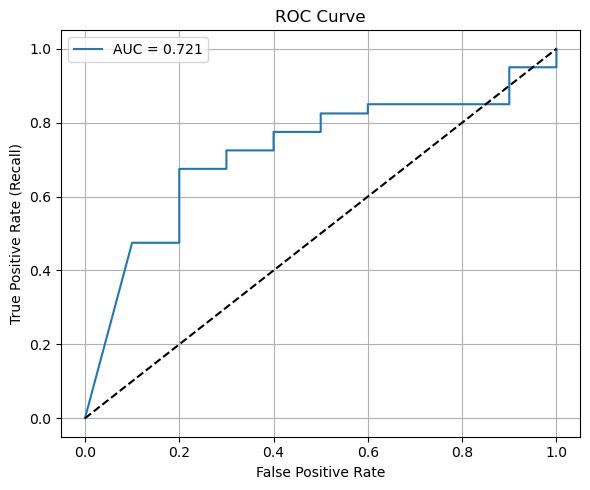

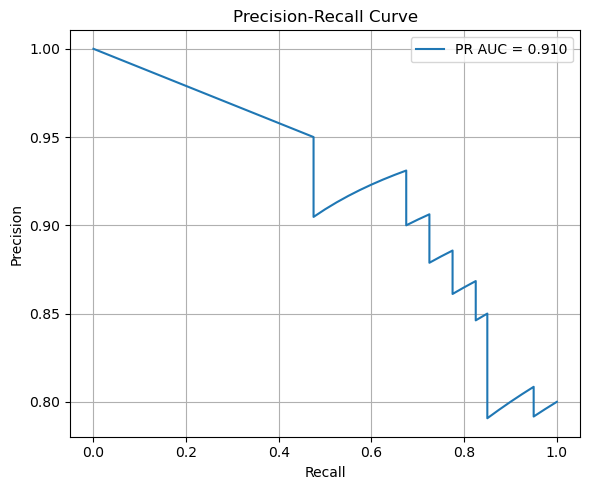

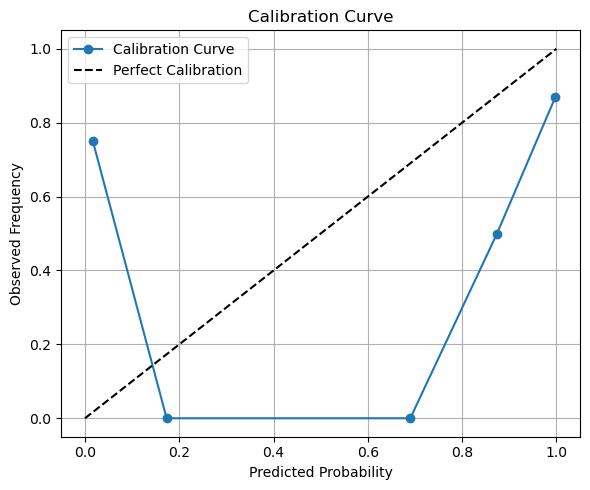

In [101]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def evaluate_binary_classifier(df, output_prefix=""):
    """
    Evaluate binary classifier performance with ROC, PR, and Calibration curves.
    
    Parameters:
    - df: pandas DataFrame with columns ['True_Label', 'Pred_Prob']
    - output_prefix: prefix to prepend to output image filenames (optional)
    """

    # === Compute Metrics ===
    roc_auc = roc_auc_score(df['True_Label'], df['Pred_Prob'])
    pr_auc = average_precision_score(df['True_Label'], df['Pred_Prob'])

    print(f"\nEvaluation Metrics:")
    print(f"  ROC AUC: {roc_auc:.3f}")
    print(f"  PR AUC:  {pr_auc:.3f}")

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}roc_curve.png")
    plt.show()

    # === Precision-Recall Curve ===
    precision, recall, _ = precision_recall_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}pr_curve.png")
    plt.show()

    # === Calibration Curve ===
    prob_true, prob_pred = calibration_curve(df['True_Label'], df['Pred_Prob'], n_bins=10, strategy='uniform')
    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Calibration Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}calibration_curve.png")
    plt.show()

df = export_predictions_binary(model, X_test, y_test)
evaluate_binary_classifier(df, output_prefix="binary_cnn_")

In [103]:
# === Save Model to Disk ===
model.save("binary_cnn_model_0.74.keras")
print(" Model saved to binary_cnn_model_0.74.keras")

 Model saved to binary_cnn_model_0.74.keras


In [27]:
# ========================= Deep Binary CNN Full Pipeline =========================
# === Imports ===
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix

# === Set Random Seeds for Reproducibility ===
def set_seeds(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === Load & Preprocess Data Functions ===
def parse_info_cfg(info_path):
    ed = es = group = None
    with open(info_path, 'r') as f:
        for line in f:
            if "ED:" in line:
                ed = int(line.split(":")[1].strip())
            elif "ES:" in line:
                es = int(line.split(":")[1].strip())
            elif "Group:" in line:
                group = line.split(":")[1].strip()
    return ed, es, group

def load_mid_slice(path):
    img = nib.load(path).get_fdata()
    mid = img.shape[2] // 2
    return cv2.resize(img[:, :, mid], (128, 128))

def load_tensor(base_path, pid, ed, es):
    ed_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{ed:02d}_gt.nii"))
    es_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{es:02d}_gt.nii"))
    tensor = np.stack([ed_img, es_img], axis=-1).astype(np.float32)
    return tensor / np.max(tensor)

def load_dataset_binary(base_dir):
    X = []
    y = []

    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"):
            continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            if group == "ARV":
                continue
            tensor = load_tensor(path, patient, ed, es)
            X.append(tensor)
            y.append(0 if group == "NOR" else 1)
        except Exception as e:
            print(f"Skipping {patient}: {e}")
    
    X = np.stack(X).astype(np.float32)
    y = np.array(y).astype(np.int32)
    return X, y

# === Build Deep CNN Model ===
def build_deep_2d_model(input_shape=(128, 128, 2), learning_rate=0.0003):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

# === Define Prediction Function Once (Avoid Retracing) ===
@tf.function(reduce_retracing=True)
def predict_fn(model, x):
    return model(x, training=False)

# === Export Predictions ===
def export_predictions_binary(model, X_test, y_test, output_csv="predictions_deep2dcnn.csv"):
    y_pred_probs = predict_fn(model, X_test).numpy().flatten()
    y_pred_bin = (y_pred_probs > 0.5).astype(int)

    patient_ids = sorted([pid for pid in os.listdir('./database/testing') if pid.startswith("patient")])
    if len(patient_ids) != len(y_pred_bin):
        patient_ids = patient_ids[:len(y_pred_bin)]

    df = pd.DataFrame({
        'PatientID': patient_ids,
        'True_Label': y_test,
        'Pred_Prob': y_pred_probs,
        'Pred_Label': y_pred_bin,
        'Correct': y_test == y_pred_bin
    })

    df.to_csv(output_csv, index=False)
    print(f"Saved predictions to {output_csv}")
    return df

# === Main Pipeline ===
if __name__ == "__main__":
    print("Setting seeds for reproducibility...")
    set_seeds(42)

    print("Loading training and testing data...")
    X_train, y_train = load_dataset_binary('./database/training')
    X_test, y_test = load_dataset_binary('./database/testing')

    print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

    print("Building deep CNN model...")
    model = build_deep_2d_model(input_shape=(128, 128, 2))

    print("Training model...")
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=16,
        verbose=1
    )

    print("Predicting and exporting results...")
    df = export_predictions_binary(model, X_test, y_test)

    cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["Pred: NOR", "Pred: ABN"]))

    report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

    print("\nClassification Report:")
    print(report_df[['precision', 'recall', 'f1-score', 'support']])

Setting seeds for reproducibility...
Loading training and testing data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 70.31it/s]


Training samples: (100, 128, 128, 2), Testing samples: (50, 128, 128, 2)
Building deep CNN model...
Training model...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6291 - loss: 2.6798 - precision: 0.8271 - recall: 0.7159 - val_accuracy: 0.2000 - val_loss: 0.7170 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7388 - loss: 0.9776 - precision: 0.9151 - recall: 0.7605 - val_accuracy: 0.2000 - val_loss: 0.7015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7555 - loss: 1.0459 - precision: 0.8606 - recall: 0.8355 - val_accuracy: 0.2000 - val_loss: 0.7460 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8322 - loss: 0.7605 - precision: 0.9071 - recall: 0.8850 - val_accuracy: 0.2000 - val_loss: 0.7614 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
7/7 ━━━━━━

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === Load Predictions ===
df = pd.read_csv("predictions_deep2dcnn.csv")

# === Confusion Matrix ===
cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
print("Confusion Matrix (Deep 2D CNN):")
print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["Pred: NOR", "Pred: ABN"]))

# === Classification Report ===
report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

print("\nClassification Report (Deep 2D CNN):")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

Confusion Matrix (Deep 2D CNN):
     Pred: NOR  Pred: ABN
NOR          8          2
ABN         10         30

Classification Report (Deep 2D CNN):
              precision  recall  f1-score  support
NOR               0.444   0.800     0.571    10.00
ABN               0.938   0.750     0.833    40.00
accuracy          0.760   0.760     0.760     0.76
macro avg         0.691   0.775     0.702    50.00
weighted avg      0.839   0.760     0.781    50.00


In [33]:
# === Print Overall Accuracy ===
accuracy = report['accuracy']
print(f"\n Overall Accuracy: {accuracy:.3f}")


 Overall Accuracy: 0.760


Saved predictions to predictions_deep2dcnn.csv

Evaluation Metrics:
  ROC AUC: 0.862
  PR AUC:  0.966


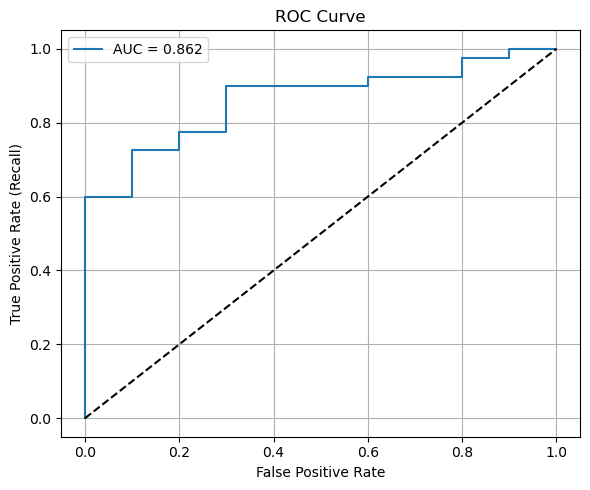

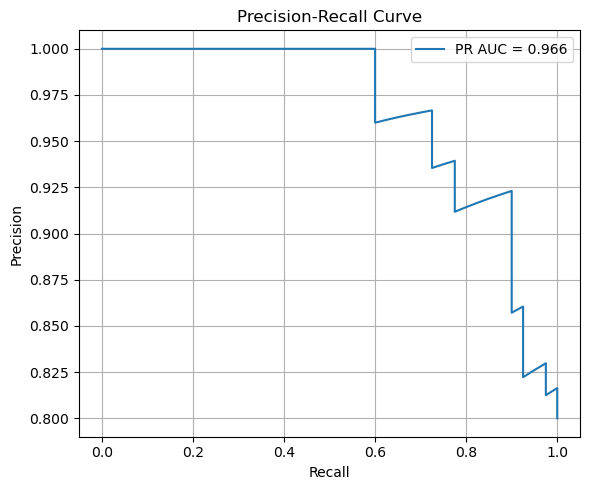

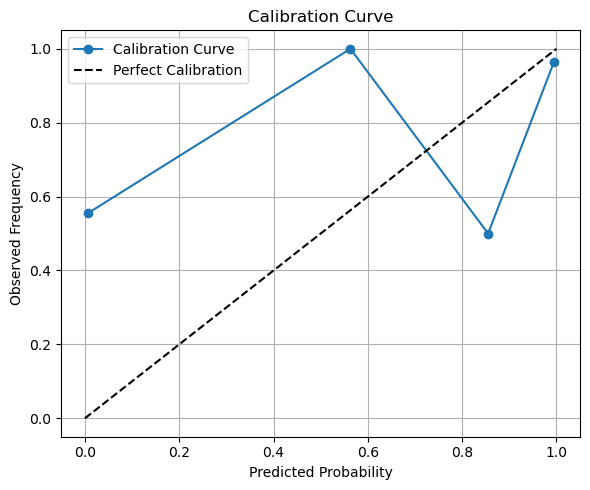

In [35]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def evaluate_binary_classifier(df, output_prefix=""):
    """
    Evaluate binary classifier performance with ROC, PR, and Calibration curves.
    
    Parameters:
    - df: pandas DataFrame with columns ['True_Label', 'Pred_Prob']
    - output_prefix: prefix to prepend to output image filenames (optional)
    """

    # === Compute Metrics ===
    roc_auc = roc_auc_score(df['True_Label'], df['Pred_Prob'])
    pr_auc = average_precision_score(df['True_Label'], df['Pred_Prob'])

    print(f"\nEvaluation Metrics:")
    print(f"  ROC AUC: {roc_auc:.3f}")
    print(f"  PR AUC:  {pr_auc:.3f}")

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}roc_curve.png")
    plt.show()

    # === Precision-Recall Curve ===
    precision, recall, _ = precision_recall_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}pr_curve.png")
    plt.show()

    # === Calibration Curve ===
    prob_true, prob_pred = calibration_curve(df['True_Label'], df['Pred_Prob'], n_bins=10, strategy='uniform')
    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Calibration Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}calibration_curve.png")
    plt.show()

df = export_predictions_binary(model, X_test, y_test)
evaluate_binary_classifier(df, output_prefix="binary_deep2dcnn_")

In [37]:
# === Save Model to Disk ===
model.save("binary_deep2dcnn_model_0.76.keras")
print(" Model saved to binary_deep2dcnn_model_0.76.keras")

 Model saved to binary_deep2dcnn_model_0.76.keras


In [59]:
# ========================= Improved Deep Binary CNN Full Pipeline =========================
# === Imports ===
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix

# === Set Random Seeds for Reproducibility ===
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Set TensorFlow deterministic ops if necessary
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === Load & Preprocess Data Functions ===
def parse_info_cfg(info_path):
    """Parse ED, ES, and group information from Info.cfg file."""
    ed = es = group = None
    with open(info_path, 'r') as f:
        for line in f:
            if "ED:" in line:
                ed = int(line.split(":")[1].strip())
            elif "ES:" in line:
                es = int(line.split(":")[1].strip())
            elif "Group:" in line:
                group = line.split(":")[1].strip()
    return ed, es, group

def load_mid_slice(path):
    """Load and resize the middle slice from a 3D NIfTI image."""
    img = nib.load(path).get_fdata()
    mid = img.shape[2] // 2
    return cv2.resize(img[:, :, mid], (128, 128))

def load_tensor(base_path, pid, ed, es):
    """Load ED and ES frames, stack them into a 2-channel tensor."""
    ed_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{ed:02d}_gt.nii"))
    es_img = load_mid_slice(os.path.join(base_path, f"{pid}_frame{es:02d}_gt.nii"))
    tensor = np.stack([ed_img, es_img], axis=-1)
    tensor = tensor.astype(np.float32)
    return tensor / np.max(tensor)  # Normalize to [0,1]

def load_dataset_binary(base_dir):
    """Load dataset and labels for binary classification, ignoring ARV group."""
    X = []
    y = []

    for patient in tqdm(sorted(os.listdir(base_dir))):
        if not patient.startswith("patient"):
            continue
        try:
            path = os.path.join(base_dir, patient)
            ed, es, group = parse_info_cfg(os.path.join(path, "Info.cfg"))
            if group == "ARV":
                continue  # Skip ARV group
            tensor = load_tensor(path, patient, ed, es)
            X.append(tensor)
            label = 0 if group == "NOR" else 1
            y.append(label)
        except Exception as e:
            print(f"Skipping {patient}: {e}")

    X = np.stack(X, axis=0)
    y = np.array(y)
    return X, y

# === Build Deep 2D CNN Model ===
def build_deep_2d_model(input_shape=(128, 128, 2), learning_rate=0.0003):
    """Define and compile the deep 2D CNN model."""
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

# === Export Predictions ===
def export_predictions_binary(model, X_test, y_test, output_csv="predictions_deep2dcnn.csv"):
    """Export model predictions to CSV."""
    y_pred_probs = model.predict(X_test, batch_size=16).flatten()
    y_pred_bin = (y_pred_probs > 0.5).astype(int)

    # Match predictions with patient IDs
    patient_ids = sorted([pid for pid in os.listdir('./database/testing') if pid.startswith("patient")])
    if len(patient_ids) != len(y_pred_bin):
        patient_ids = patient_ids[:len(y_pred_bin)]

    df = pd.DataFrame({
        'PatientID': patient_ids,
        'True_Label': y_test,
        'Pred_Prob': y_pred_probs,
        'Pred_Label': y_pred_bin,
        'Correct': y_test == y_pred_bin
    })

    df.to_csv(output_csv, index=False)
    print(f"Saved predictions to {output_csv}")
    return df

# === Main Execution ===
if __name__ == "__main__":
    print("Setting seeds for reproducibility...")
    set_seeds(42)

    print("Loading training and testing data...")
    X_train, y_train = load_dataset_binary('./database/training')
    X_test, y_test = load_dataset_binary('./database/testing')

    print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

    print("Building deep model...")
    model = build_deep_2d_model(input_shape=(128, 128, 2))

    print("Training model...")
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=16,
        verbose=1
    )

    print("Predicting and exporting results...")
    df = export_predictions_binary(model, X_test, y_test)

    # === Evaluation ===
    cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
    print("\nConfusion Matrix (Deep 2D CNN):")
    print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["Pred: NOR", "Pred: ABN"]))

    report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

    print("\nClassification Report (Deep 2D CNN):")
    print(report_df[['precision', 'recall', 'f1-score', 'support']])


Setting seeds for reproducibility...
Loading training and testing data...


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  8.22it/s]


Training samples: (100, 128, 128, 2), Testing samples: (50, 128, 128, 2)
Building deep model...
Training model...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - accuracy: 0.6389 - loss: 1.7034 - precision: 0.7999 - recall: 0.7523 - val_accuracy: 0.8000 - val_loss: 0.6864 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7672 - loss: 0.5061 - precision: 0.8106 - recall: 0.9338 - val_accuracy: 0.8000 - val_loss: 0.6855 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6705 - loss: 0.6223 - precision: 0.7963 - recall: 0.8040 - val_accuracy: 0.8000 - val_loss: 0.6762 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8393 - loss: 0.4450 - precision: 0.8364 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.6687 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accurac

In [63]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === Load Predictions ===
df = pd.read_csv("predictions_deep2dcnn.csv")

# === Confusion Matrix ===
cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
print("Confusion Matrix (Deep 2D CNN):")
print(pd.DataFrame(cm, index=["NOR", "ABN"], columns=["Pred: NOR", "Pred: ABN"]))

# === Classification Report ===
report = classification_report(df['True_Label'], df['Pred_Label'], target_names=["NOR", "ABN"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

print("\nClassification Report (Deep 2D CNN):")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

Confusion Matrix (Deep 2D CNN):
     Pred: NOR  Pred: ABN
NOR          6          4
ABN          3         37

Classification Report (Deep 2D CNN):
              precision  recall  f1-score  support
NOR               0.667   0.600     0.632    10.00
ABN               0.902   0.925     0.914    40.00
accuracy          0.860   0.860     0.860     0.86
macro avg         0.785   0.762     0.773    50.00
weighted avg      0.855   0.860     0.857    50.00


In [65]:
accuracy = report['accuracy']
print(f"\n Overall Accuracy: {accuracy:.3f}")


 Overall Accuracy: 0.860


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Saved predictions to predictions_deep2dcnn.csv

Evaluation Metrics:
  ROC AUC: 0.865
  PR AUC:  0.949


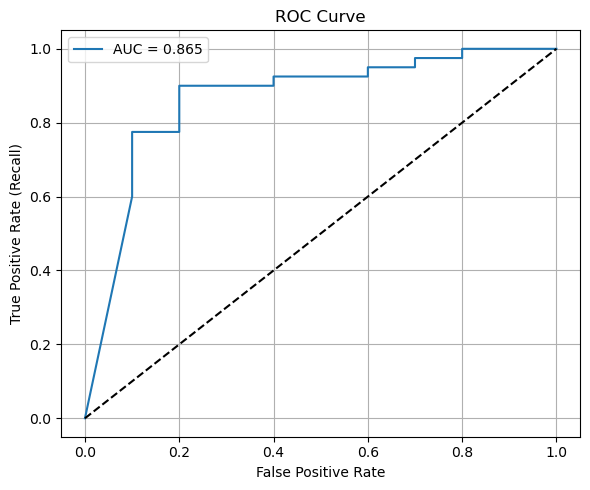

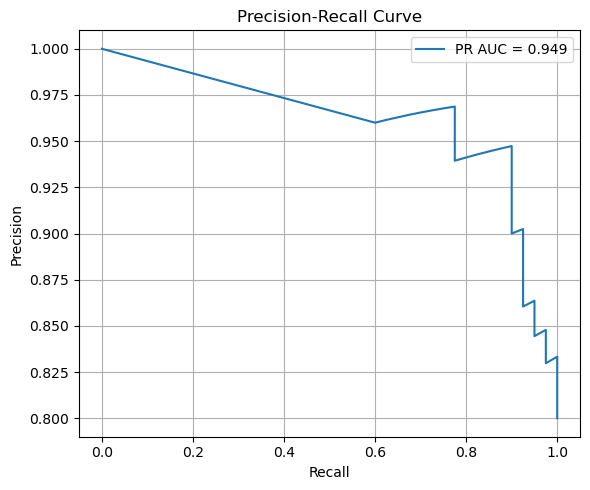

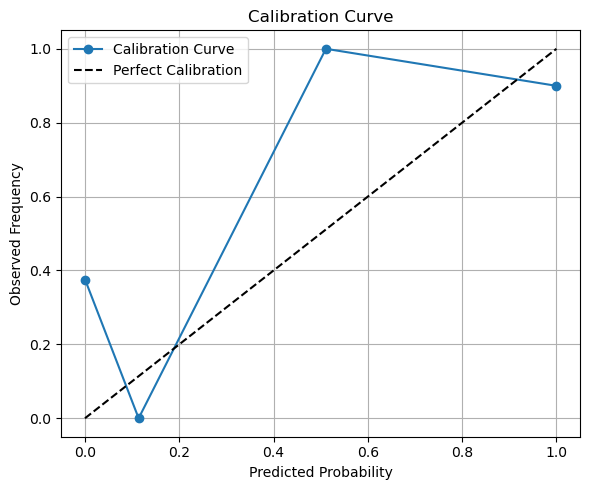

In [67]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def evaluate_binary_classifier(df, output_prefix=""):
    """
    Evaluate binary classifier performance with ROC, PR, and Calibration curves.
    
    Parameters:
    - df: pandas DataFrame with columns ['True_Label', 'Pred_Prob']
    - output_prefix: prefix to prepend to output image filenames (optional)
    """

    # === Compute Metrics ===
    roc_auc = roc_auc_score(df['True_Label'], df['Pred_Prob'])
    pr_auc = average_precision_score(df['True_Label'], df['Pred_Prob'])

    print(f"\nEvaluation Metrics:")
    print(f"  ROC AUC: {roc_auc:.3f}")
    print(f"  PR AUC:  {pr_auc:.3f}")

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}roc_curve.png")
    plt.show()

    # === Precision-Recall Curve ===
    precision, recall, _ = precision_recall_curve(df['True_Label'], df['Pred_Prob'])
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}pr_curve.png")
    plt.show()

    # === Calibration Curve ===
    prob_true, prob_pred = calibration_curve(df['True_Label'], df['Pred_Prob'], n_bins=10, strategy='uniform')
    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Calibration Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}calibration_curve.png")
    plt.show()

df = export_predictions_binary(model, X_test, y_test)
evaluate_binary_classifier(df, output_prefix="final_binary_deep2dcnn_")

In [69]:
# === Save Model to Disk ===
model.save("binary_deep2dcnn_model_final.keras")
print(" Model saved to binary_deep2dcnn_model_final.keras")

 Model saved to binary_deep2dcnn_model_final.keras


In [71]:
pip install shap lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 8.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283840 sha256=5c7bba6f6676eff5128fe6f373877220be3f053d339ae3c4e4013e51d46185f5
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [117]:
# === SHAP/LIME for Deep 2D CNN ===
import matplotlib.pyplot as plt
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# === SHAP Visualization ===
def generate_shap_plot(model, X_train, X_test, class_names=["NOR", "ABN"]):
    """
    Generate SHAP plots for 2-channel medical images.
    """
    print("\nGenerating SHAP explanations...")
    
    # Select a small subset of background samples
    background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]
    
    try:
        # Create SHAP explainer with explicit model input/output
        explainer = shap.DeepExplainer(
            (model.input, model.output),
            background
        )
        
        # Calculate SHAP values for first test sample only
        test_sample = X_test[0:1]  # Keep as batch of 1
        shap_values = explainer.shap_values(test_sample)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # Plot each channel separately
        for channel in range(2):
            plt.figure(figsize=(10, 10))
            channel_name = "ED" if channel == 0 else "ES"
            
            # Get absolute SHAP values for this channel
            channel_shap = np.abs(shap_values[0, :, :, channel])
            
            # Plot heatmap
            plt.imshow(channel_shap, cmap='hot')
            plt.colorbar(label='SHAP value magnitude')
            plt.title(f"SHAP Values - {channel_name} Channel")
            plt.axis('off')
            plt.savefig(f"shap_channel_{channel+1}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
        print("SHAP heatmaps saved as shap_channel_1.png and shap_channel_2.png")
        
    except Exception as e:
        print(f"Error generating SHAP plots: {str(e)}")
        print("Consider using GradientExplainer instead for complex models.")
        
# === LIME Visualization ===
def generate_lime_plot(model, X_test, class_names=["NOR", "ABN"]):
    """
    Generate LIME plots for 2-channel medical images.
    """
    print("\nGenerating LIME explanations...")
    
    # Custom prediction function for LIME
    def predict_fn(images):
        # Convert LIME's RGB images to our 2-channel format
        if images.ndim == 4 and images.shape[-1] == 3:
            # Use first channel and duplicate to create 2 channels
            images = np.stack([images[..., 0], images[..., 0]], axis=-1)
        return model.predict(images)
    
    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Explain first sample
    try:
        print("\nGenerating LIME explanation for first sample...")
        
        # Convert our 2-channel image to 3-channel for LIME
        rgb_image = np.stack([X_test[0, :, :, 0]] * 3, axis=-1)
        
        explanation = explainer.explain_instance(
            rgb_image.astype(np.double),
            predict_fn,
            top_labels=1,
            hide_color=0,
            num_samples=500
        )
        
        # Get explanation for positive class
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=True
        )
        
        # Plot explanation
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp, mask))
        plt.title("LIME Explanation (Most Important Regions)")
        plt.axis('off')
        plt.savefig("lime_explanation.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        print("LIME plot saved as lime_explanation.png")
        
    except Exception as e:
        print(f"Error generating LIME explanation: {str(e)}")
        
# === Add to Main Execution ===
if __name__ == "__main__":
    # ... (your existing code)
    
    print("Generating model explanation plots...")
    
    # Generate SHAP plots (may take some time)
    generate_shap_plot(model, X_train, X_test)
    
    # Generate LIME plots
    generate_lime_plot(model, X_test)
    
    print("All explanation plots generated!")

Generating model explanation plots...

Generating SHAP explanations...


E:\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(20, 128, 128, 2))']
  warnings.warn(msg)
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(40, 128, 128, 2))']
  warnings.warn(msg)
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(1, 128, 128, 2))']
  warnings.warn(msg

SHAP heatmaps saved as shap_channel_1.png and shap_channel_2.png

Generating LIME explanations...

Generating LIME explanation for first sample...


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [129]:
# === SHAP Visualization ===
import shap
import matplotlib.pyplot as plt
import numpy as np

def generate_shap_plot(model, X_train, X_test, class_names=["NOR", "ABN"]):
    """
    Generate SHAP summary plots for each image channel.

    Args:
        model: Trained Keras model
        X_train: Training data (used as background)
        X_test: Test samples to explain
        class_names: Optional class names
    """
    print("\nGenerating SHAP explanations...")

    # SHAP background
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

    # SHAP DeepExplainer
    explainer = shap.DeepExplainer(model, background)
    test_samples = X_test[:5]
    shap_values = explainer.shap_values(test_samples)

    # For binary classification, shap_values is a list
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    num_samples, height, width, channels = test_samples.shape

    for channel in range(channels):
        print(f"\nSHAP Summary Plot for Channel {channel+1}:")
        channel_shap = shap_values[:, :, :, channel].reshape(num_samples, -1)
        channel_data = test_samples[:, :, :, channel].reshape(num_samples, -1)

        channel_name = "ED" if channel == 0 else "ES"
        feature_names = [f"{channel_name} Pixel {i}" for i in range(height * width)]

        shap.summary_plot(
            channel_shap,
            features=channel_data,
            feature_names=feature_names,
            class_names=class_names,
            show=False
        )
        plt.title(f"SHAP Summary - {channel_name} Image")
        plt.tight_layout()
        plt.savefig(f"shap_summary_channel_{channel+1}.png", dpi=300)
        plt.close()

    print("Saved SHAP plots: 'shap_summary_channel_1.png' and 'shap_summary_channel_2.png'")

# === Add to Main Execution ===
if __name__ == "__main__":
    # ... (your existing code)

    print("Generating SHAP explanation plots...")
    
    # Generate SHAP plots (may take some time)
    generate_shap_plot(model, X_train, X_test)

    print("All explanation plots generated!")


Generating SHAP explanation plots...

Generating SHAP explanations...


E:\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(100, 128, 128, 2))']
  warnings.warn(msg)
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(200, 128, 128, 2))']
  warnings.warn(msg)
E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_169
Received: inputs=['Tensor(shape=(5, 128, 128, 2))']
  warnings.warn(m


SHAP Summary Plot for Channel 1:

SHAP Summary Plot for Channel 2:


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14280\1784928623.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Saved SHAP plots: 'shap_summary_channel_1.png' and 'shap_summary_channel_2.png'
All explanation plots generated!


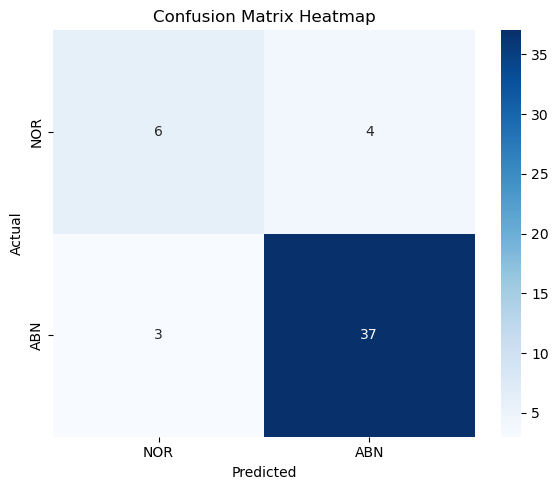

In [119]:
# === Bias Identification, Visualization & Mitigation ===
# === A. Confusion Matrix Heatmap ===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df['True_Label'], df['Pred_Label'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NOR', 'ABN'], yticklabels=['NOR', 'ABN'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=300)
plt.show()

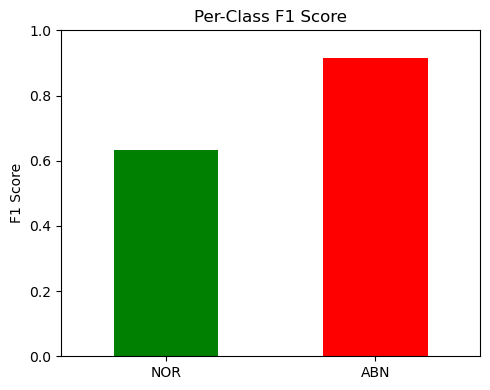

In [121]:
# === B. Per-Class F1 Score Bar Plot ===
f1_scores = report_df.loc[["NOR", "ABN"], "f1-score"]

plt.figure(figsize=(5, 4))
f1_scores.plot(kind='bar', color=['green', 'red'])
plt.title("Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("f1_score_barplot.png", dpi=300)
plt.show()

In [135]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [133]:
import mlflow
import mlflow.tensorflow

mlflow.tensorflow.autolog()

2025/04/30 18:44:00 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 1.0000 - loss: 1.6927e-06 - precision: 1.0000 - recall: 1.0000

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 1.0000 - loss: 1.6779e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8400 - val_loss: 1.4719 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 1.0000 - loss: 2.2540e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8600 - val_loss: 1.4763 - val_precision: 0.9024 - val_recall: 0.9250
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 1.0000 - loss: 5.7745e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8400 - val_loss: 1.4823 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 1.0000 - loss: 1.7572e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8600 - val_loss: 1.4880 - val_precision: 0.9024 - val_recall: 0.9250
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - accuracy: 1.0000 - loss: 2.1371e-06 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8600 - val_loss:

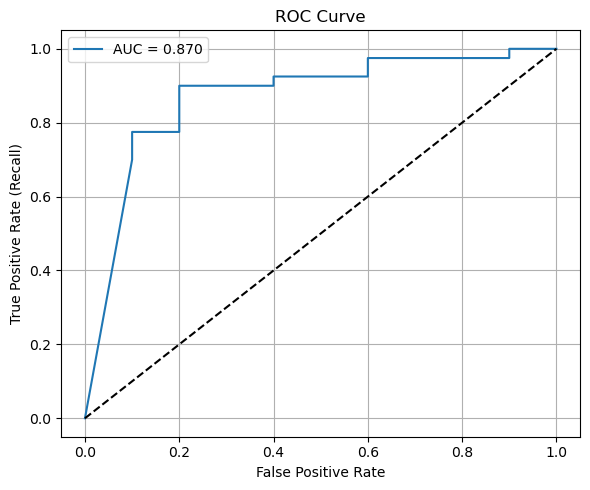

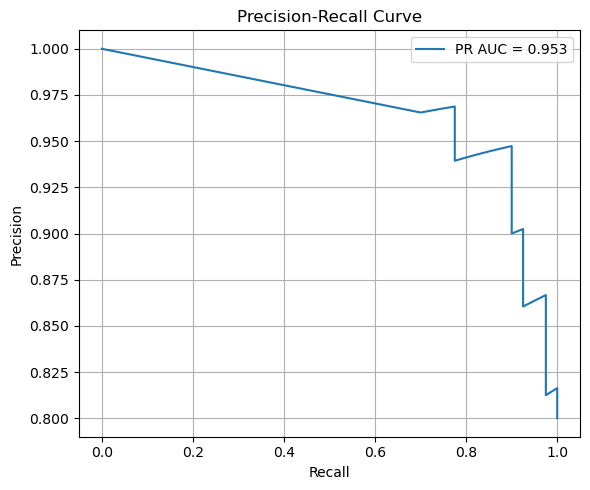

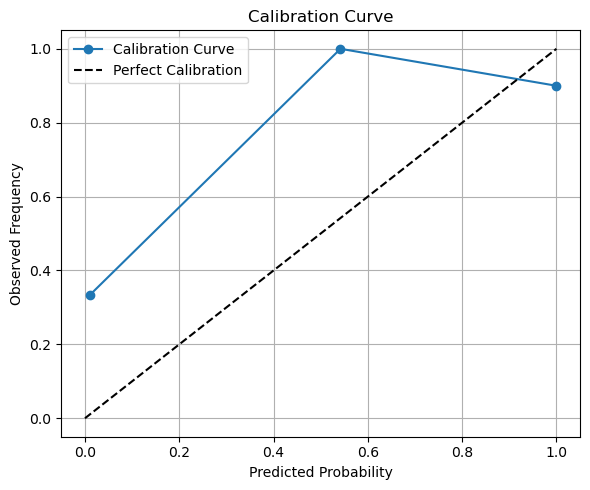

In [137]:
with mlflow.start_run():
    # Training code
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=16,
        verbose=1
    )

    # Evaluation code
    df = export_predictions_binary(model, X_test, y_test)
    evaluate_binary_classifier(df, output_prefix="final_binary_deep2dcnn_")
    model.save("binary_deep2dcnn_model_final.keras")


In [139]:
mlflow.log_param("learning_rate", 0.0003)
mlflow.log_param("batch_size", 16)
mlflow.log_metric("final_accuracy", accuracy)

In [143]:
mlflow.log_artifact("final_binary_deep2dcnn_calibration_curve.png")
mlflow.log_artifact("final_binary_deep2dcnn_pr_curve.png")
mlflow.log_artifact("final_binary_deep2dcnn_roc_curve.png")
mlflow.log_artifact("shap_channel_1.png")
mlflow.log_artifact("shap_channel_2.png")
mlflow.log_artifact("shap_summary_channel_1.png")
mlflow.log_artifact("shap_summary_channel_2.png")
mlflow.log_artifact("lime_explanation.png")
mlflow.log_artifact("confusion_matrix_heatmap.png")
mlflow.log_artifact("f1_score_barplot.png")

In [145]:
mlflow.keras.log_model(model, "final_model")

2025/04/30 19:08:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/30 19:09:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
